In [18]:
# pip install facenet-pytorch


In [12]:

import os
import numpy as np
from PIL import Image
from PIL import ImageOps, ExifTags

import matplotlib.pyplot as plt
from facenet_pytorch import MTCNN , InceptionResnetV1
from matplotlib import pyplot
from numpy import savez_compressed
from sklearn.preprocessing import Normalizer, LabelEncoder

from tqdm import tqdm

from numpy import asarray


import torch
from torch.utils.data import Dataset
from torchvision import transforms

In [13]:
def handle_orientation(img):
    try:
        for orientation in ExifTags.TAGS.keys():
            if ExifTags.TAGS[orientation] == 'Orientation':
                break
        exif = dict(img._getexif().items())

        if exif[orientation] == 3:
            img = img.rotate(180, expand=True)
        elif exif[orientation] == 6:
            img = img.rotate(270, expand=True)
        elif exif[orientation] == 8:
            img = img.rotate(90, expand=True)
    except (AttributeError, KeyError, IndexError):
        # Ignore if there's no EXIF data or if it doesn't contain orientation information
        pass

    return img

In [14]:
def face(filename, mtcnn, img_size=(160, 160)):
    
    try:
        image = Image.open(filename)
    except IsADirectoryError:
        # Skip directories and return None
        print(f"Skipping directory: {filename}")
        return None
    image = handle_orientation(image)  # Correct orientation
    image = image.convert('RGB')
    img_arr = asarray(image)

    if img_arr.shape[0] < img_size[0] and img_arr.shape[1] < img_size[1]:
        print(f"Skipping {filename} due to small image size: {img_arr.shape[:2]}")
        return None

    image = Image.fromarray(img_arr)
    image = image.resize(img_size)
    img_arr = asarray(image)

    boxes, probs = mtcnn.detect(img_arr)

    if boxes is not None:
        x1, y1, x2, y2 = map(int, boxes[0])  # Convert to integers
        x1, y1 = abs(x1), abs(y1)
        x2, y2 = x1 + (x2 - x1), y1 + (y2 - y1)

        face = img_arr[y1:y2, x1:x2]
        image = Image.fromarray(face)
        image = image.resize(img_size)
        face_arr = asarray(image)
        return face_arr
    else:
        return None


In [15]:
def plot_faces_in_folder(folder_path, mtcnn, rows=2, cols=7, img_size=(160, 160)):
    # Get the list of files in the folder
    file_list = os.listdir(folder_path)

    pyplot.figure(figsize=(15, 8))
    for i, filename in enumerate(file_list, start=1):
        
        file_path = os.path.join(folder_path, filename)

        
        extracted_face = face(file_path, mtcnn)
        if extracted_face is None:
            img = Image.open(file_path)
            plt.imshow(img)
            plt.title(f'Invalid extraction for {filename}')
            plt.show()
            continue

        print(f"Face shape for {filename}: {extracted_face.shape}")


        if i > rows * cols:
            print("Maximum number of subplots reached. Exiting.")
            break

        # Display the face with subplot
        pyplot.subplot(rows, cols, i)
        pyplot.axis('off')
        pyplot.imshow(extracted_face)

    pyplot.show()


In [16]:
%pwd

'/home/aritra/AML_Files'

In [17]:
folder_path=  '//home//aritra//AML_Files//Facial_Train//Aakash//'
len(os.listdir(folder_path))

42

Face shape for 20220313_093812.jpg: (160, 160, 3)
Face shape for 20220525_233831.jpg: (160, 160, 3)
Face shape for 20220528_130921.jpg: (160, 160, 3)
Face shape for 20220403_193759.jpg: (160, 160, 3)
Face shape for 20220729_111416.jpg: (160, 160, 3)
Face shape for 20220503_112752.jpg: (160, 160, 3)
Face shape for 20220518_121807.jpg: (160, 160, 3)
Face shape for 20220106_151446.jpg: (160, 160, 3)
Face shape for 20220310_104536.jpg: (160, 160, 3)
Face shape for 20220811_214207.jpg: (160, 160, 3)
Face shape for 20220530_122754.jpg: (160, 160, 3)
Face shape for 20220523_112702.jpg: (160, 160, 3)
Face shape for 20220801_112709.jpg: (160, 160, 3)
Face shape for 20220218_133716.jpg: (160, 160, 3)
Face shape for 20220219_122528.jpg: (160, 160, 3)
Maximum number of subplots reached. Exiting.


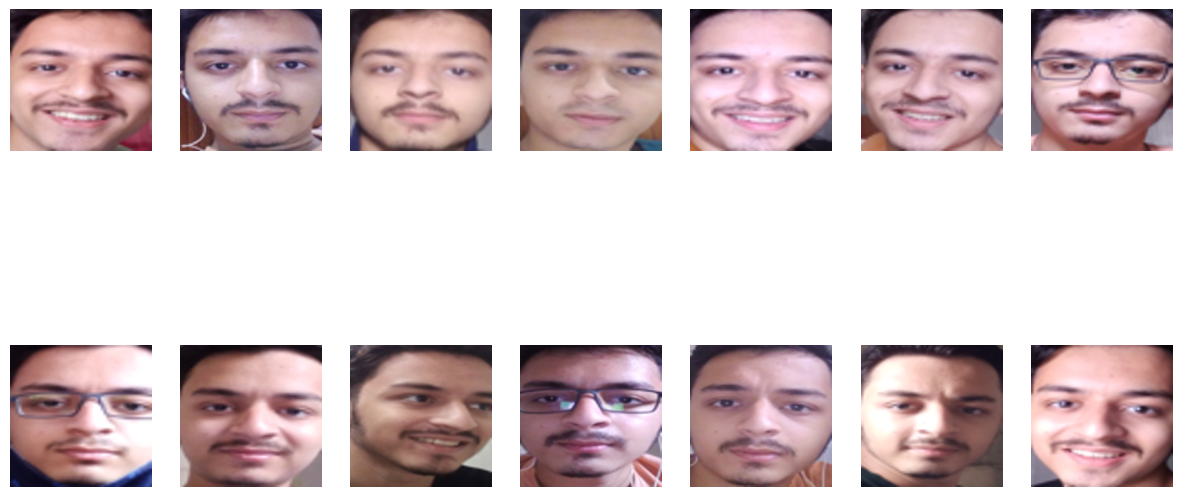

In [61]:
mtcnn = MTCNN()
plot_faces_in_folder(folder_path, mtcnn)

In [9]:
def save_faces_in_folder(folder_path, mtcnn, output_folder, img_size=(160, 160)):
    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Get the list of files in the folder
    file_list = os.listdir(folder_path)

    for filename in file_list:
        file_path = os.path.join(folder_path, filename)

        extracted_face = face(file_path, mtcnn, img_size)
        if extracted_face is not None:
            # Save the extracted face using Image library
            output_path = os.path.join(output_folder, f"{filename}_face.png")
            Image.fromarray(extracted_face).save(output_path)
            print(f"Face saved: {output_path}")




In [10]:
# input_folder = '//home//aritra//AML_Files//Facial_Train//Aakash//'
# output_folder = '//home//aritra//AML_Files//faces_train//Aakash'
# mtcnn = MTCNN()
# save_faces_in_folder(input_folder, mtcnn, output_folder)

In [1]:
# train_folder = '//home//aritra//AML_Files//Facial_Train//'
# Output_folder = '//home//aritra//AML_Files//faces_train//'

# for folder_name in os.listdir(train_folder_path):
#     input_folder_path = os.path.join(train_folder_path,folder_name)
#     Output_folder_path = os.path.join(Output_folder,folder_name)
#     mtcnn = MTCNN()
#     save_faces_in_folder(input_folder_path, mtcnn, Output_folder_path)    
#     break
        
    

### Creating Train faces

In [63]:
import os

input_folder = '//home//aritra//AML_Files//Facial_Train//'
output_base_folder = '//home//aritra//AML_Files//faces_train//'
mtcnn = MTCNN()

# Get a list of subfolders in the input folder
subfolders = [f.name for f in os.scandir(input_folder) if f.is_dir()]

for subfolder in subfolders:
    # Construct full paths for input and output folders
    subfolder_input_path = os.path.join(input_folder, subfolder)
    subfolder_output_path = os.path.join(output_base_folder, subfolder)

    # Create the output folder if it doesn't exist
    if not os.path.exists(subfolder_output_path):
        os.makedirs(subfolder_output_path)

    # Save faces in the current subfolder
    save_faces_in_folder(subfolder_input_path, mtcnn, subfolder_output_path)


Face saved: //home//aritra//AML_Files//faces_train//manish rai/622450-517746-virat-kohli-110816.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//manish rai/virat-kohli1616307024255.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//manish rai/pjimage-2021-04-09T212802.134.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//manish rai/desktop-wallpaper-virat-kohli-smile-thumbnail.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//manish rai/MixCollage-11-Nov-2023-09-17-PM-8676-770x433.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//manish rai/india-captain-virat-kohli-during-a-press-conference-at-lords-london-PDCPEK.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//manish rai/2023105175427682_download--2023-10-05T175654-646.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//manish rai/74624353.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//manish rai/virat-kohli-faces

/home/aritra/miniconda3/envs/test/lib/python3.11/site-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Face saved: //home//aritra//AML_Files//faces_train//Abhishek Kumar /IMG-20240113-WA0039.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Abhishek Kumar /IMG20231221093348.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Abhishek Kumar /IMG20240101123548.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Abhishek Kumar /IMG20230918205206.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Abhishek Kumar /IMG20231016132035.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Abhishek Kumar /IMG20231223161240.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Abhishek Kumar /IMG20231020112755.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Abhishek Kumar /IMG20230924104119.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Abhishek Kumar /IMG_20190105_134616128.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Abhishek Kumar /IMG20231023135529.jpg_face.png
Fac

Face saved: //home//aritra//AML_Files//faces_train//Rahul_12310890/20240119_183225.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Rahul_12310890/20240119_183858.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Rahul_12310890/20240119_182843.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Rahul_12310890/20240119_183404.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Rahul_12310890/20240119_183534.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Rahul_12310890/20240119_182712.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Rahul_12310890/20240119_183926.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Rahul_12310890/20240119_182707.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Rahul_12310890/20240119_182828.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Rahul_12310890/20240119_182820.jpg_face.png
Face saved: //home//aritra//AML_Files//f

Face saved: //home//aritra//AML_Files//faces_train//Mallikarjun/IMG_20240119_075902.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Mallikarjun/IMG_20240119_080036.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Mallikarjun/IMG_20240119_074610.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Mallikarjun/IMG_20240119_075131.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Mallikarjun/IMG_20240119_075924.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Mallikarjun/IMG_20240119_080159.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Mallikarjun/IMG_20240119_074618.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Mallikarjun/IMG_20240119_075213.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Mallikarjun/IMG_20240119_075559.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Mallikarjun/IMG_20240119_080127.jpg_face.png
Face saved: //home//aritra//AM

Face saved: //home//aritra//AML_Files//faces_train//Aryan Kumar/photo_2024-01-19_23-46-32 (2).jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Aryan Kumar/photo_2024-01-19_23-45-16.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Aryan Kumar/photo_2024-01-19_23-45-56.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Aryan Kumar/photo_2024-01-19_23-45-46.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Aryan Kumar/photo_2024-01-19_23-46-49.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Aryan Kumar/photo_2024-01-19_23-46-32.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Aryan Kumar/photo_2024-01-19_23-46-34 (2).jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Aryan Kumar/photo_2024-01-19_23-47-21 (2) - 02.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Aryan Kumar/photo_2024-01-19_23-47-06 (2).jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//

Face saved: //home//aritra//AML_Files//faces_train//harshit kumar/wp5332857.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//harshit kumar/73039888.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//harshit kumar/ms-dhoni-16901.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//harshit kumar/EsavsgjUwAMhhXn.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//harshit kumar/topimg_21123_mahendra_singh_dhoni.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//harshit kumar/dhoni-2.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//harshit kumar/1597260667_ee9hrtbumaaqwlg.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//harshit kumar/ms_dhoni_with_cup_smiley_face_helmet_coat_suit_back_image_hd_dhoni-HD.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//harshit kumar/MS-Dhoni-Moin-Khan_tvindialive.in_.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//harshit kumar

Face saved: //home//aritra//AML_Files//faces_train//Moyank Giri/bachchan_top20211121121441202111211334141637502395_1024.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Moyank Giri/bc75b92735d7c30b71acd78d4cf5ff8e.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Moyank Giri/images15.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Moyank Giri/images17.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Moyank Giri/13548641725971.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Moyank Giri/images21.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Moyank Giri/amitabh-bachchan-don-film-bollywood-actor-png-favpng-65VbjGKRnDfk6DDS2jAWh4d7U_t.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Moyank Giri/amitabh-bachchan-smile-face-mobile-pic.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Moyank Giri/images12.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_tr

Face saved: //home//aritra//AML_Files//faces_train//Anumula Chaitanya Sai/IMG_4129.JPG_face.png
Face saved: //home//aritra//AML_Files//faces_train//Anumula Chaitanya Sai/IMG_4209.JPG_face.png
Face saved: //home//aritra//AML_Files//faces_train//Anumula Chaitanya Sai/IMG_4218.JPG_face.png
Face saved: //home//aritra//AML_Files//faces_train//Anumula Chaitanya Sai/IMG_4147.JPG_face.png
Face saved: //home//aritra//AML_Files//faces_train//Anumula Chaitanya Sai/IMG_4137.JPG_face.png
Face saved: //home//aritra//AML_Files//faces_train//Anumula Chaitanya Sai/IMG_4152.JPG_face.png
Face saved: //home//aritra//AML_Files//faces_train//Anumula Chaitanya Sai/IMG_4118.JPG_face.png
Face saved: //home//aritra//AML_Files//faces_train//Anumula Chaitanya Sai/IMG_4249.JPG_face.png
Face saved: //home//aritra//AML_Files//faces_train//Anumula Chaitanya Sai/IMG_4138.JPG_face.png
Face saved: //home//aritra//AML_Files//faces_train//Anumula Chaitanya Sai/IMG_4117.JPG_face.png
Face saved: //home//aritra//AML_Files//f

Face saved: //home//aritra//AML_Files//faces_train//Aditya_Sharma_12140070/IMG20240119230306.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Aditya_Sharma_12140070/IMG20240119225745.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Aditya_Sharma_12140070/IMG20240119225739.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Aditya_Sharma_12140070/IMG-20240119-WA0104.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Aditya_Sharma_12140070/IMG-20240119-WA0090.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Aditya_Sharma_12140070/IMG-20240119-WA0162.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Aditya_Sharma_12140070/IMG-20240119-WA0122.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Aditya_Sharma_12140070/IMG-20240119-WA0171.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Aditya_Sharma_12140070/IMG-20240119-WA0130.jpg_face.png
Face saved: //home//aritra//AML_Fi

Face saved: //home//aritra//AML_Files//faces_train//Animesh Singh/IMG-20240119-WA0052.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Animesh Singh/IMG-20240119-WA0103.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Animesh Singh/IMG-20240119-WA0111.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Animesh Singh/IMG-20240119-WA0021.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Animesh Singh/IMG-20240119-WA0120.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Animesh Singh/IMG-20240119-WA0056.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Animesh Singh/IMG-20240119-WA0017.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Animesh Singh/IMG-20240119-WA0106.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Animesh Singh/IMG-20240119-WA0094.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Animesh Singh/IMG-20240119-WA0050.jpg_face.png
Face saved

Face saved: //home//aritra//AML_Files//faces_train//Aritra/IMG_20240114_170916_31.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Aritra/IMG_20240114_170916_56.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Aritra/IMG_20240114_170916_52.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Aritra/IMG_20240114_170916_66.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Aritra/IMG_20240114_170916_100.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Aritra/IMG_20240114_170916_85.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Aritra/IMG_20240114_170916_87.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Aritra/IMG_20240114_170916_57.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Aritra/IMG_20240114_170916_29.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Aritra/IMG_20240114_170916_80.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_trai

Face saved: //home//aritra//AML_Files//faces_train//rashmika_mandanna/10043.webp_face.png
Face saved: //home//aritra//AML_Files//faces_train//rashmika_mandanna/10049.jpg_face.png
Skipping //home//aritra//AML_Files//Facial_Train//rashmika_mandanna/10063.png due to small image size: (16, 16)
Face saved: //home//aritra//AML_Files//faces_train//rashmika_mandanna/10080.jpeg_face.png
Face saved: //home//aritra//AML_Files//faces_train//rashmika_mandanna/10050.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//rashmika_mandanna/10048.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//rashmika_mandanna/10022.jpg_face.png
Skipping //home//aritra//AML_Files//Facial_Train//rashmika_mandanna/10028.png due to small image size: (16, 16)
Face saved: //home//aritra//AML_Files//faces_train//rashmika_mandanna/10079.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//rashmika_mandanna/10045.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//rashmika_m

Face saved: //home//aritra//AML_Files//faces_train//Brishti/image_a22.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Brishti/image_a90.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Brishti/image_d83.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Brishti/image_a60.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Brishti/image_d53.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Brishti/image_d68.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Brishti/image_a83.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Brishti/image_d39.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Brishti/image_d3.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Brishti/image_d49.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Brishti/image_d12.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Brishti/image_a82.jpg_face.png
Face 

Face saved: //home//aritra//AML_Files//faces_train//Prarabdh/IMG20240124133801_BURST013.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Prarabdh/IMG20240124133806_BURST003.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Prarabdh/IMG20240124133806_BURST005.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Prarabdh/IMG20240124133806_BURST010.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Prarabdh/IMG20240124133815_BURST018.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Prarabdh/IMG20240124133801_BURST016.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Prarabdh/IMG20240124133809_BURST004.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Prarabdh/IMG20240124133801_BURST012.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Prarabdh/IMG20240124133815_BURST007.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Prarabdh/IMG20240124133809_BURST003.jpg

Face saved: //home//aritra//AML_Files//faces_train//Adah_sharma/10032.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Adah_sharma/10082.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Adah_sharma/10067.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Adah_sharma/10065.jpg_face.png
Skipping //home//aritra//AML_Files//Facial_Train//Adah_sharma/10001.jpg due to small image size: (100, 100)
Face saved: //home//aritra//AML_Files//faces_train//Adah_sharma/10041.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Adah_sharma/10035.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Adah_sharma/10075.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Adah_sharma/10029.jpg_face.png
Skipping //home//aritra//AML_Files//Facial_Train//Adah_sharma/10015.jpg due to small image size: (100, 100)
Skipping //home//aritra//AML_Files//Facial_Train//Adah_sharma/10011.jpg due to small image size: (100, 100)
Face saved: 

Face saved: //home//aritra//AML_Files//faces_train//Vaibhav_Arora/20240119_185602.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Vaibhav_Arora/20240118_212001(0).jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Vaibhav_Arora/20240119_185615.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Vaibhav_Arora/20240118_212021.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Vaibhav_Arora/20240118_211921.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Vaibhav_Arora/20240119_185522.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Vaibhav_Arora/20240119_185608.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Vaibhav_Arora/20240119_185640.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Vaibhav_Arora/20240118_211928.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Vaibhav_Arora/20240119_185521.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_tr

Face saved: //home//aritra//AML_Files//faces_train//Uplab Rajak/IMG20240119182342.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Uplab Rajak/IMG20240119182516.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Uplab Rajak/IMG20240119182531.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Uplab Rajak/IMG20240119182046.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Uplab Rajak/IMG20240119182533.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Uplab Rajak/IMG20240119182221.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Uplab Rajak/IMG20240119182259.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Uplab Rajak/IMG20240119182248.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Uplab Rajak/IMG20240119182446.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Uplab Rajak/IMG20240119182451.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train

Face saved: //home//aritra//AML_Files//faces_train//Mohit Agarwala/IMG20240119181336.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Mohit Agarwala/IMG20240119181633.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Mohit Agarwala/IMG20240119180825.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Mohit Agarwala/IMG20240119180939.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Mohit Agarwala/IMG20240119181133.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Mohit Agarwala/IMG20240119181139.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Mohit Agarwala/IMG20240119180918.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Mohit Agarwala/IMG20240119181126.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Mohit Agarwala/IMG20240119180940.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Mohit Agarwala/IMG20240119181651.jpg_face.png
Face saved: //home//

Face saved: //home//aritra//AML_Files//faces_train//tanmoy/20240119_200516.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//tanmoy/20240119_201010.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//tanmoy/20240119_200518.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//tanmoy/20240119_201043.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//tanmoy/20240119_200847.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//tanmoy/20240119_200743.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//tanmoy/20240119_200321.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//tanmoy/20240119_200628.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//tanmoy/20240119_200437.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//tanmoy/20240119_200913.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//tanmoy/20240119_200728.jpg_face.png
Face saved: //home//aritra//AML_

Face saved: //home//aritra//AML_Files//faces_train//Deepika/image (6).jpeg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Deepika/image (7).jpeg_face.png
Face saved: //home//aritra//AML_Files//faces_train//AditiShukla/photo_5_2024-01-18_18-16-45.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//AditiShukla/photo_10_2024-01-18_18-18-33.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//AditiShukla/photo_8_2024-01-15_23-35-31.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//AditiShukla/photo_14_2024-01-15_23-38-19.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//AditiShukla/photo_13_2024-01-15_23-38-19.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//AditiShukla/photo_6_2024-01-18_18-18-19.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//AditiShukla/photo_6_2024-01-15_23-38-19.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//AditiShukla/photo_2_2024-01-18_18-18-25.jp

Face saved: //home//aritra//AML_Files//faces_train//AditiShukla/15.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//AditiShukla/photo_12_2024-01-15_23-38-19.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//AditiShukla/photo_10_2024-01-15_23-37-42.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//AditiShukla/photo_2_2024-01-18_18-18-33.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//AditiShukla/photo_9_2024-01-15_23-35-48.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//AditiShukla/43.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//AditiShukla/photo_1_2024-01-18_18-16-30.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//AditiShukla/photo_6_2024-01-15_23-38-03.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//AditiShukla/photo_4_2024-01-18_18-17-32.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//AditiShukla/49.jpg_face.png
Face saved: //home//ari

Face saved: //home//aritra//AML_Files//faces_train//Amogh/IMG20240114215346.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Amogh/IMG20240114215336.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Amogh/IMG20240114215426.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Amogh/IMG20240114215629.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Amogh/IMG20240114215403.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Amogh/IMG20240114215430.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Amogh/IMG20240114215425.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Amogh/IMG20240114215352.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Amogh/IMG20240114215442.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Amogh/IMG20240114215420.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Amogh/IMG20240114215410.jpg_face.png
Face saved: //home//a

Face saved: //home//aritra//AML_Files//faces_train//Kishan/20240117_223837.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Kishan/20240117_223913.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Kishan/20240118_203401.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Kishan/20240117_223817.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Kishan/20240118_203147.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Kishan/20240118_203153.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Kishan/20240117_223844_HDR.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Kishan/20240117_223921.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Kishan/20240117_223935_HDR.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Kishan/20240118_203426.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Kishan/20240118_203132.jpg_face.png
Face saved: //home//arit

Face saved: //home//aritra//AML_Files//faces_train//Sanjib Patra /20230801_173716.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Sanjib Patra /20230601_142241.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Sanjib Patra /IMG-20240119-WA0007.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Sanjib Patra /IMG-20231022-WA0014.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Sanjib Patra /IMG-20240119-WA0038.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Sanjib Patra /IMG-20240119-WA0004.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Sanjib Patra /IMG-20240119-WA0034.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Sanjib Patra /IMG-20240119-WA0036.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Sanjib Patra /IMG-20230928-WA0003.jpeg_face.png
Face saved: //home//aritra//AML_Files//faces_train//Naveetha/10070.jpg_face.png
Face saved: //home//aritra//AML_File

### Creating Valid_Face Images

In [19]:

input_folder = '//home//aritra//AML_Files//Facial_Valid//'
output_base_folder = '//home//aritra//AML_Files//faces_Valid//'
mtcnn = MTCNN()

# Get a list of subfolders in the input folder
subfolders = [f.name for f in os.scandir(input_folder) if f.is_dir()]

for subfolder in subfolders:
    # Construct full paths for input and output folders
    subfolder_input_path = os.path.join(input_folder, subfolder)
    subfolder_output_path = os.path.join(output_base_folder, subfolder)

    # Create the output folder if it doesn't exist
    if not os.path.exists(subfolder_output_path):
        os.makedirs(subfolder_output_path)

    # Save faces in the current subfolder
    save_faces_in_folder(subfolder_input_path, mtcnn, subfolder_output_path)


Face saved: //home//aritra//AML_Files//faces_Valid//manish rai/MCM-Man-Crush-Monday-Virat-Kholi.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Valid//manish rai/virat-kohli-beard-celebrity-mask.png_face.png
Face saved: //home//aritra//AML_Files//faces_Valid//manish rai/2021-02-25T102405Z_299690162_RC2MZL9UPDRH_RTRMADP_3_CRICKET-TEST-IND-ENG_1614643322561_1614643341751.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Valid//manish rai/Virat-Kohli-2-1.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Valid//manish rai/e3ed46937c8f240f6729e6b5acafb744.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Valid//manish rai/61888146.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Valid//manish rai/Virat-Kohli-looks-on-as-England-inch-closer-to-win-during-India-vs-England-T20-World-Cup-semifinal.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Valid//manish rai/Virat-century.jpg_auto=format,compress&fmt=webp&format=webp&w=1200&h=900&dpr=1.jp

Face saved: //home//aritra//AML_Files//faces_Valid//Mallikarjun/IMG_20240119_075203.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Valid//Mallikarjun/IMG_20240119_074929_1.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Valid//Aryan Kumar/photo_2024-01-19_23-47-08 (2).jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Valid//Aryan Kumar/photo_2024-01-19_23-44-58.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Valid//Aryan Kumar/photo_2024-01-19_23-45-23.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Valid//Aryan Kumar/photo_2024-01-19_23-45-05.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Valid//Aryan Kumar/photo_2024-01-19_23-45-41.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Valid//Aryan Kumar/photo_2024-01-19_23-45-40.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Valid//Aryan Kumar/photo_2024-01-19_23-46-18.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Valid//Aryan Kumar/photo_2024-01-1

Face saved: //home//aritra//AML_Files//faces_Valid//Anumula Chaitanya Sai/IMG_4144.JPG_face.png
Face saved: //home//aritra//AML_Files//faces_Valid//Anumula Chaitanya Sai/IMG_4208.JPG_face.png
Face saved: //home//aritra//AML_Files//faces_Valid//Anumula Chaitanya Sai/IMG_4245.JPG_face.png
Face saved: //home//aritra//AML_Files//faces_Valid//Anumula Chaitanya Sai/IMG_4213.JPG_face.png
Face saved: //home//aritra//AML_Files//faces_Valid//Anumula Chaitanya Sai/IMG_4116.JPG_face.png
Face saved: //home//aritra//AML_Files//faces_Valid//Anumula Chaitanya Sai/IMG_4214.JPG_face.png
Face saved: //home//aritra//AML_Files//faces_Valid//Anumula Chaitanya Sai/IMG_4128.JPG_face.png
Face saved: //home//aritra//AML_Files//faces_Valid//Anumula Chaitanya Sai/IMG_4231.JPG_face.png
Face saved: //home//aritra//AML_Files//faces_Valid//Anumula Chaitanya Sai/IMG_4235.JPG_face.png
Face saved: //home//aritra//AML_Files//faces_Valid//Anumula Chaitanya Sai/IMG_4115.JPG_face.png
Face saved: //home//aritra//AML_Files//f

Face saved: //home//aritra//AML_Files//faces_Valid//Aritra/IMG_20240117_213656.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Valid//Aritra/IMG_20240114_170916_26.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Valid//Aritra/IMG_20240114_170916_70.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Valid//Aritra/IMG_20240114_170916_22.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Valid//Aritra/IMG_20240114_170916_82.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Valid//Aritra/IMG_20240114_170916_27.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Valid//Aritra/IMG_20240114_170916_8.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Valid//Aritra/IMG_20240114_170916_14.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Valid//Aritra/IMG_20240114_170916_76.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Valid//Aritra/IMG_20240114_170916_28.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Valid//Ar

Face saved: //home//aritra//AML_Files//faces_Valid//Adah_sharma/10047.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Valid//Adah_sharma/10021.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Valid//Adah_sharma/10045.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Valid//Adah_sharma/10068.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Valid//Adah_sharma/10098.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Valid//Adah_sharma/10034.jpeg_face.png
Face saved: //home//aritra//AML_Files//faces_Valid//Adah_sharma/10030.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Valid//Adah_sharma/10080.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Valid//Adah_sharma/10028.jpg_face.png
Skipping //home//aritra//AML_Files//Facial_Valid//Adah_sharma/10006.jpg due to small image size: (100, 100)
Face saved: //home//aritra//AML_Files//faces_Valid//Vaibhav_Arora/20240119_185519.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Vali

Face saved: //home//aritra//AML_Files//faces_Valid//Mohit Agarwala/IMG20240119180824.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Valid//Mohit Agarwala/IMG20240119180711.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Valid//Mohit Agarwala/IMG20240119180929.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Valid//Mohit Agarwala/IMG20240119181328.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Valid//Mohit Agarwala/IMG20240119181132_01.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Valid//Mohit Agarwala/IMG20240119181433.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Valid//Mohit Agarwala/IMG20240119181151.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Valid//Mohit Agarwala/IMG20240119181649.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Valid//Mohit Agarwala/IMG20240119180827.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Valid//Mohit Agarwala/IMG20240119181650.jpg_face.png
Face saved: //hom

Face saved: //home//aritra//AML_Files//faces_Valid//AditiShukla/24.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Valid//AditiShukla/29.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Valid//AditiShukla/photo_1_2024-01-18_18-18-25.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Valid//AditiShukla/photo_8_2024-01-15_23-37-31.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Valid//AditiShukla/photo_6_2024-01-15_23-37-42.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Valid//AditiShukla/36.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Valid//Amogh/IMG20240114215433.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Valid//Amogh/IMG20240114215426_01.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Valid//Amogh/IMG20240114215414.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Valid//Amogh/IMG20240114215405.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Valid//Amogh/IMG20240114215451.jpg_face.p

### Creating Test face Images

In [21]:

input_folder = '//home//aritra//AML_Files//Facial_Test//'
output_base_folder = '//home//aritra//AML_Files//faces_Test//'
mtcnn = MTCNN()

# Get a list of subfolders in the input folder
subfolders = [f.name for f in os.scandir(input_folder) if f.is_dir()]

for subfolder in subfolders:
    # Construct full paths for input and output folders
    subfolder_input_path = os.path.join(input_folder, subfolder)
    subfolder_output_path = os.path.join(output_base_folder, subfolder)

    # Create the output folder if it doesn't exist
    if not os.path.exists(subfolder_output_path):
        os.makedirs(subfolder_output_path)

    # Save faces in the current subfolder
    save_faces_in_folder(subfolder_input_path, mtcnn, subfolder_output_path)


Face saved: //home//aritra//AML_Files//faces_Test//manish rai/kohli-t20-wc-new-getty_1635068337484_1635068341564.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Test//manish rai/4c29b5f1-1994-441e-85e3-2c666195954d.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Test//manish rai/c891b56d96214df8bcc302c8d806475b.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Test//manish rai/46.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Test//manish rai/844195-833368-virat-kohli.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Test//manish rai/cocky-yet-calm-the-avatars-of-virat-kohli.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Test//manish rai/virat-kohli-ipl-2022-16503861083x2.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Test//manish rai/virat-kohli_650x400_81473848805.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Test//Abhishek Kumar /IMG20231230213836.jpg_face.png
Face saved: //home//aritra//AML_Files//face

Face saved: //home//aritra//AML_Files//faces_Test//Aditya_Sharma_12140070/IMG-20240119-WA0094.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Test//Aditya_Sharma_12140070/IMG-20240119-WA0100.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Test//Aditya_Sharma_12140070/IMG-20240119-WA0138.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Test//Aditya_Sharma_12140070/IMG-20240119-WA0134.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Test//Aditya_Sharma_12140070/IMG-20240119-WA0044.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Test//Aditya_Sharma_12140070/IMG-20240119-WA0018.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Test//Aditya_Sharma_12140070/IMG-20240119-WA0026.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Test//Aditya_Sharma_12140070/IMG-20240119-WA0054.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Test//Aditya_Sharma_12140070/IMG-20240119-WA0036.jpg_face.png
Face saved: //home//aritra//AML_Files

Face saved: //home//aritra//AML_Files//faces_Test//Vaibhav_Arora/20240118_212142.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Test//Vaibhav_Arora/20240119_185531.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Test//Vaibhav_Arora/20240119_185638.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Test//Vishesh_Thakur/20240119_235359.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Test//Vishesh_Thakur/20240119_235645.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Test//Vishesh_Thakur/20240119_235516.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Test//Vishesh_Thakur/20240119_235454.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Test//Vishesh_Thakur/20240119_235451.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Test//Vishesh_Thakur/20240119_235646.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Test//Vishesh_Thakur/20240119_235642.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Test//Vi

Face saved: //home//aritra//AML_Files//faces_Test//Sanjib Patra /IMG-20230909-WA0000.jpeg_face.png
Face saved: //home//aritra//AML_Files//faces_Test//Sanjib Patra /IMG_20220404_104814.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Test//Sanjib Patra /20240119_141211.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Test//Sanjib Patra /IMG-20240119-WA0014.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Test//Sanjib Patra /20230823_190627.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Test//Sanjib Patra /IMG-20240119-WA0029.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Test//Naveetha/10019.jpg_face.png
Skipping //home//aritra//AML_Files//Facial_Test//Naveetha/10009.jpg due to small image size: (100, 100)
Face saved: //home//aritra//AML_Files//faces_Test//Naveetha/10017.jpg_face.png
Face saved: //home//aritra//AML_Files//faces_Test//Naveetha/10042.jpg_face.png
Skipping //home//aritra//AML_Files//Facial_Test//Naveetha/10046.jpg due to sma